## Gym Framework

In [19]:
!pip install gym

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [20]:
import gym

# 初始化 Taxi-v3 环境
env = gym.make("Taxi-v3")
# 渲染环境当状态
# 需要注意，不同的环境会有不同的渲染模式。Taxi-v3 环境默认以字符串形式渲染。
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [26]:
# 注意在第一次执行 step 前需要 reset 一次
env.reset()
env.step(action=0)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


In [27]:
env.step(action=0)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


In [28]:
env.step(action=0)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


## Random Action Agent

### 初始化 Random Agent 并且记录所有的步骤状态

In [29]:
import gym
import tqdm
import random
import numpy as np
# seaborn 是 matplotlib 框架的高级封装，可以很方便绘制一些常见图像
# 如果没有安装需要在终端通过 pip 命令安装
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

plt.rcParams['figure.dpi'] = 180

# 此处取了环境对象里的 env 对象，因为 make 方法返回的 env 对象带有最高尝试次数限制
# 即尝试 200 次以后自动判别为结束。此实验我们不需要这个限制
env = gym.make("Taxi-v3").env

def test_random_action_policy(episodes=100):
    episode_steps = []
    episode_frames = []
    for _ in tqdm.tqdm(range(episodes)):
        observation = env.reset()
        done = False
        step = 0
        frames = []
        while not done:
            # 随机返回一个动作
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)

            # 保存过程信息用于可视化
            frames.append({
                'frame': env.render(mode='ansi'),
                'state': observation,
                'action': action,
                'reward': reward
            })

            step += 1
        episode_frames.append(frames)
        episode_steps.append(step)
    return episode_steps, episode_frames

100%|██████████| 100/100 [00:11<00:00,  8.42it/s]


Average steps: 2491.3


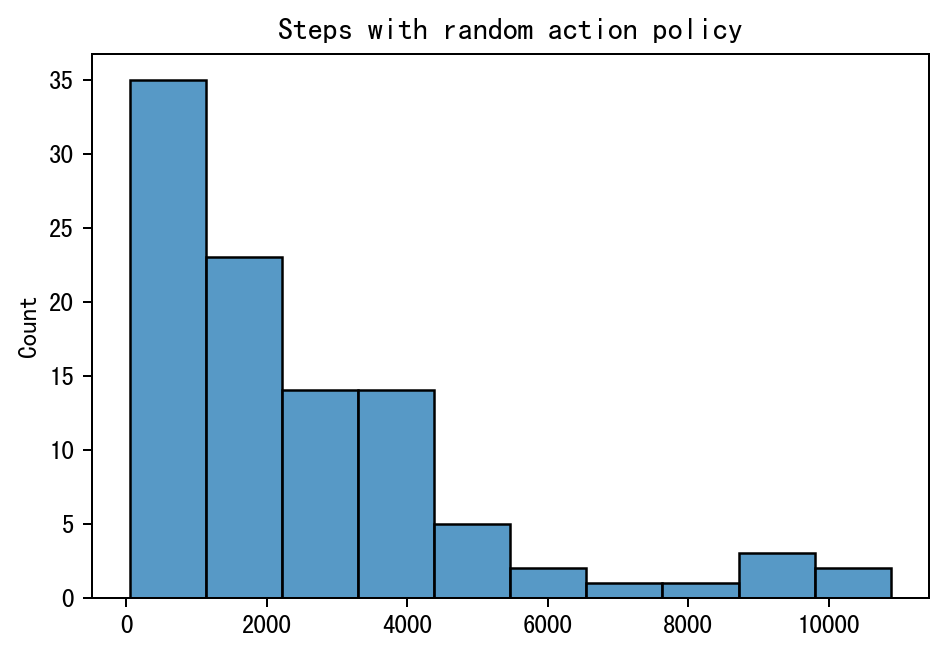

In [30]:
# 记录解决问题所用步数，并且可视化
episode_steps, episode_frames = test_random_action_policy()
sns.histplot(episode_steps)
plt.title("Steps with random action policy")
print(f"Average steps: {sum(episode_steps)/len(episode_steps)}")

In [31]:
def animate_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Time Step: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
# 随机选择一个结果进行播放
animate_frames(random.choice(episode_frames))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Time Step: 4214
State: 341
Action: 0
Reward: -1


KeyboardInterrupt: 

## Q Learning Agent

### Q Table 训练过程

In [32]:
def q_learning_action_policy(alpha = 0.1,
                             gamma = 0.6,
                             random_action_rate = 0.15,
                             episodes=100):
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    episode_steps = []
    episode_frames = []

    for episode in tqdm.trange(episodes):
        observation = env.reset()

        done, step, frames = False, 0, []

        while not done:
            # 一定比例采取随机行为，用于探索环境
            if random.uniform(0, 1) < random_action_rate:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[observation])

            # 执行行为，获取环境状态，奖励，是否完成等信息
            next_observation, reward, done, info = env.step(action)

            # 使用 Q-Learning 公式更新 Q 表
            old_value = q_table[observation, action]
            next_max = np.max(q_table[next_observation])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[observation, action] = new_value

            frames.append({
                'frame': env.render(mode='ansi'),
                'state': observation,
                'action': action,
                'reward': reward
            })

            observation = next_observation
            step += 1
        episode_steps.append(step)
        episode_frames.append(frames)
    return q_table, episode_steps, episode_frames

100%|██████████| 10000/10000 [00:21<00:00, 470.85it/s]


Average steps: 28.2084


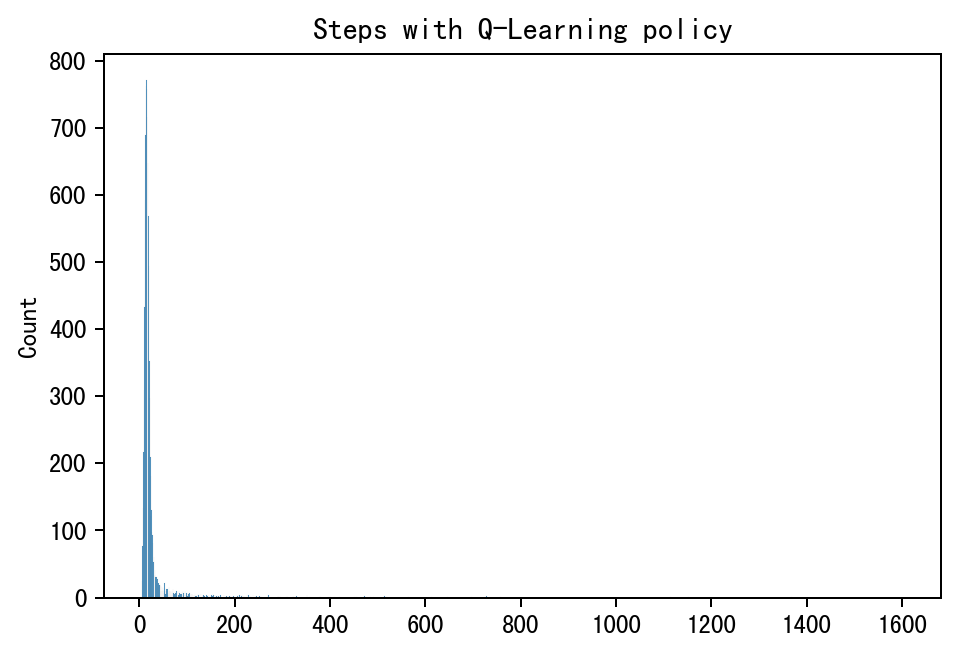

In [36]:
q_table, episode_steps, episode_frames = q_learning_action_policy(episodes=10000)
sns.histplot(episode_steps)
plt.title("Steps with Q-Learning policy")
print(f"Average steps: {sum(episode_steps)/len(episode_steps)}")

### 使用学习后的 Q Table 进行预测

In [37]:
def test_q_learning_policy(q_table,
                           episodes=100):
    episode_steps = []
    episode_frames = []
    for episode in range(episodes):
        observation = env.reset()
        done = False
        step = 0
        frames = []
        while not done:
            # 完全按照 Q 表选择下一步行为
            action = np.argmax(q_table[observation])
            observation, reward, done, info = env.step(action)
            frames.append({
                'frame': env.render(mode='ansi'),
                'state': observation,
                'action': action,
                'reward': reward
            })
            step += 1
            # 测试时候加这条件的目的是为了防止之前训练没有训练好的情况下出现死循环
            # 比如如果一直选择往上走，又没有随机行动，那么就会出现死循环，一直不结束
            if step > 2000:
                break
        episode_frames.append(frames)
        episode_steps.append(step)
    return episode_steps, episode_frames

Average steps: 331.03


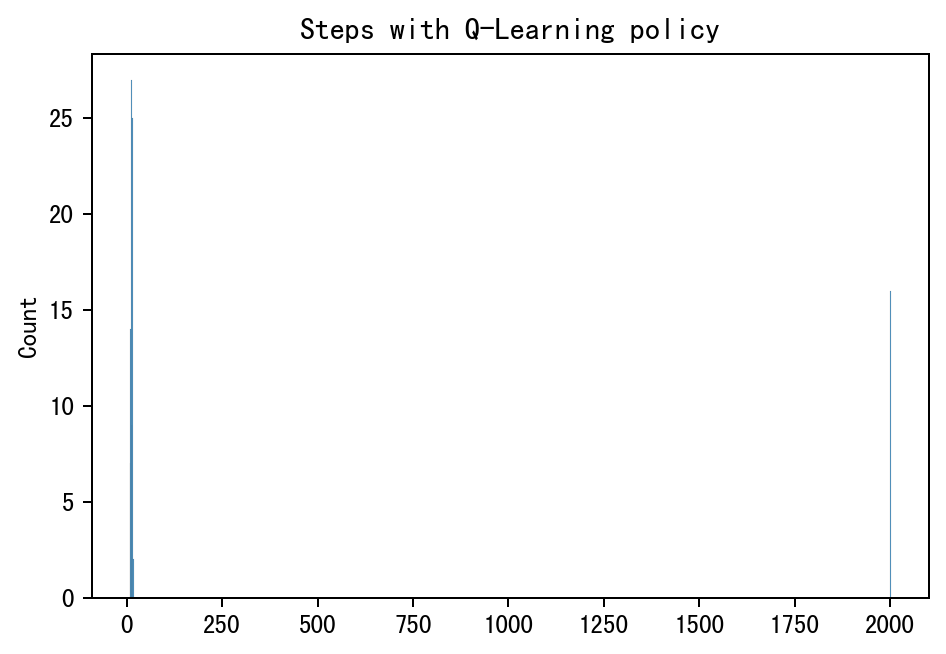

In [38]:
episode_steps, episode_frames = test_q_learning_policy(q_table)
sns.histplot(episode_steps)
plt.title("Steps with Q-Learning policy")
print(f"Average steps: {sum(episode_steps)/len(episode_steps)}")

In [18]:
q_table

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.78405644, -1.77991587, -1.77406708, -1.79219458, -1.78716265,
        -1.96      ],
       [-1.15440595, -1.14435669, -1.21588926, -1.14442103, -1.18469821,
        -2.78032398],
       ...,
       [-0.96822561, -0.9698579 , -0.96822561, -0.93854263, -1.        ,
        -1.        ],
       [-1.59716652, -1.59870234, -1.59434229, -1.58811176, -2.84279953,
        -3.64090911],
       [-0.19      , -0.19      , -0.196     ,  1.85860595, -1.        ,
        -1.        ]])